# Exercice 1: Learning a WGAN for synthetic 2-dimensional datasets

<br/><br/><br/><br/>

This practical session contains
- "QUESTION" fields in the text, that you should answer
- blocks of code that you should complete at every region marked with ### ... ###

We advise you to open the notebook on Google Colab.

### Imports

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    device = torch.device("cuda")
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device("cpu")
    dtype = torch.FloatTensor


print(device)

cuda


### Target Measure

In the following cell, we define the discrete target measure $\nu$ that will serve as dataset for this practical session.

The variable `xgrid` contains a grid of points that will be useful below to display the discriminators along training.

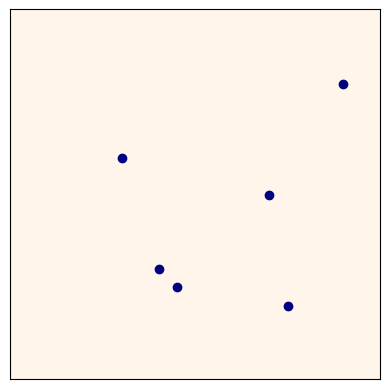

In [2]:
d = 2  # dimension of the data points

# First dataset with 6 points
n = 6
y = torch.zeros((n, d), device=device)
y[0, 0] = 0.9
y[0, 1] = 0.2
y[1, 0] = 0.75
y[1, 1] = 0.8
y[2, 0] = 0.3
y[2, 1] = 0.4
y[3, 0] = 0.4
y[3, 1] = 0.7
y[4, 0] = 0.45
y[4, 1] = 0.75
y[5, 0] = 0.7
y[5, 1] = 0.5

# # Second dataset with 100 points
# n = 100
# t = torch.pi * torch.linspace(-0.2, 1.2, n)
# y = 0.05 * torch.randn((n, d))
# y[:, 0] += torch.cos(t)
# y[:, 1] += torch.sin(2 * t)
# y = 0.5 + 0.3 * y
# y = y.to(device)

# Define masses (empirical measure on the data points)
nu = torch.ones(n, device=device) / n

# generate grid for plotting purpose
nr, nc = 256, 256
extent = (-0.5 / nc, 1 - 0.5 / nc, 1 - 0.5 / nr, -0.5 / nr)
xs = torch.linspace(0, 1, steps=nr)
ys = torch.linspace(0, 1, steps=nc)
xm, ym = torch.meshgrid(xs, ys, indexing="ij")
xm = xm.T
ym = ym.T
xgrid = torch.cat((xm.reshape(nr * nc, 1), ym.reshape(nr * nc, 1)), 1).to(device)

# Plot data points
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr, nc)), cmap="Oranges", extent=extent)  # background
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
plt.show()

## Define Generator architecture

QUESTION: Examine the layers and parameters of the following generative network.

Write a short description of the architecture of this network.

**ANSWER**:

The generative network comprises an input layer, multiple hidden layers, and an output layer. The `Generator` class initializes with parameters defining the number of input features (`n_in`), output features (`n_out`), hidden layer size (`n_hid`), number of hidden layers (`nlayers`), and the device for computation. The hidden layers are constructed in a loop and stored in a `ModuleList`, where each layer consists of a linear transformation followed by an ELU activation function. The input dimension of the first hidden layer is `n_in`, while subsequent hidden layers use `n_hid` as the input dimension. The output layer performs a linear transformation followed by a Sigmoid activation function to ensure outputs are between 0 and 1. The network applies Xavier uniform initialization to the weights of the linear layers to facilitate effective training.

In [3]:
class Generator(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hid=10, nlayers=3, device=torch.device("cpu")):
        super(Generator, self).__init__()

        self.n_in = n_in
        self.n_out = n_out
        self.n_hid = n_hid
        self.nlayers = nlayers
        self.hidden = nn.ModuleList()

        for n in range(nlayers):
            n_in_t = n_in if n == 0 else n_hid
            self.hidden.append(
                nn.Sequential(nn.Linear(n_in_t, n_hid), nn.ELU(1)).to(device)
            )

        self.out = nn.Sequential(nn.Linear(n_hid, n_out), nn.Sigmoid()).to(device)

        self.apply(self._init_weights)

    def forward(self, x):
        for n in range(self.nlayers):
            x = self.hidden[n](x)
        x = self.out(x)
        return x

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight, 1.0)
            if module.bias is not None:
                module.bias.data.zero_()

QUESTION: Plot one initial configuration of the generator (draw a batch of generated points)

**ANSWER**:

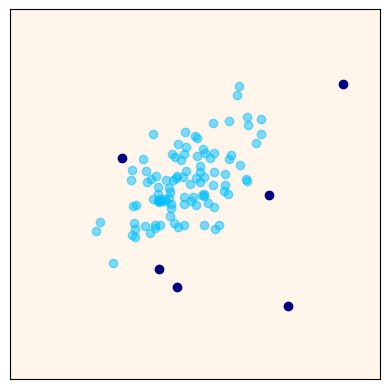

In [4]:
torch.manual_seed(0)  # initialize random seed for reproducibility

n_in = 10  # dimension of the input noise
b = 100  # batch size

# Initialize generator
G = Generator(n_in=n_in, n_out=d, n_hid=100, nlayers=3, device=device)

# Draw a batch x of generated points
#    Input noise z : standard normal with shape (b, n_in)

z = torch.randn(b, n_in, device=device)
x = G(z)

# Plot
xd = x.detach()
fig = plt.figure(dpi=100)
plt.xticks([])
plt.yticks([])
plt.imshow(np.zeros((nr, nc)), cmap="Oranges", extent=extent)  # background
plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
plt.show()

## Define Discriminator Architecture

In [5]:
class Discriminator(nn.Module):
    def __init__(self, n_in, n_hid=10):
        super(Discriminator, self).__init__()

        self.n_hid = n_hid
        self.n_in = n_in

        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, 1)

    def forward(self, x):
        y = nn.LeakyReLU(negative_slope=0.2)(self.fc1(x))
        y = nn.LeakyReLU(negative_slope=0.2)(self.fc2(y))
        y = self.fc3(y)
        return y

## Discriminator training with Weight clipping

QUESTION: For a fixed generator, train the discriminator with WGAN loss and weight clipping.

Try changing the clip_value. What do you observe?

**ANSWER**:

Changing the `clip_value` in training a discriminator with WGAN loss and weight clipping alters the range within which the discriminator's weights are bounded during optimization. A higher `clip_value` expands this range, potentially enabling the discriminator to capture more intricate features but risking instability, while a lower `clip_value` restricts the range, promoting stability but potentially hindering the discriminator's ability to discern real and fake samples effectively. In essence, adjusting `clip_value` modulates the expressiveness and stability trade-off in the WGAN training process.

[0/1000], 0.010855


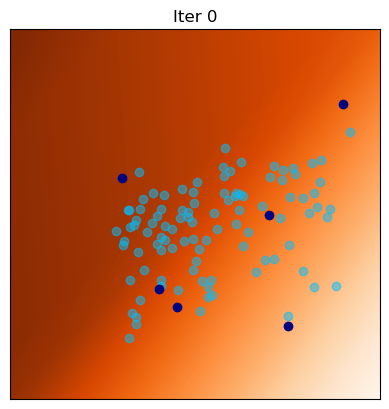

[100/1000], -0.001058


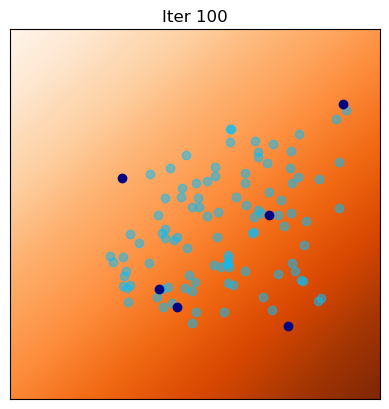

[200/1000], -0.002466


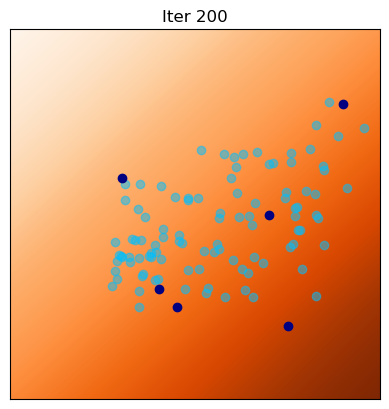

[300/1000], -0.003462


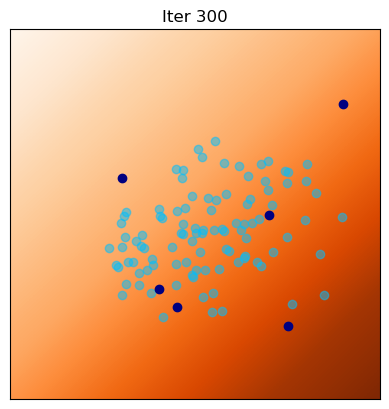

[400/1000], -0.004198


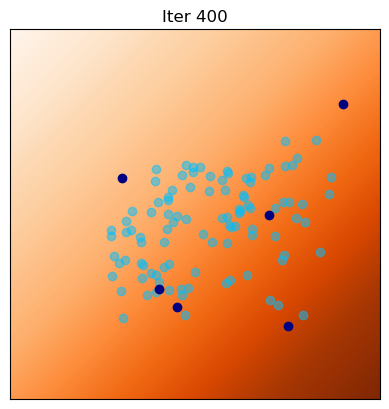

[500/1000], -0.002638


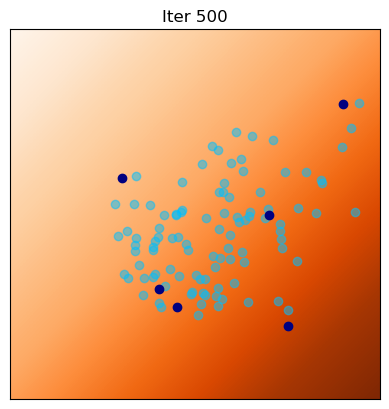

[600/1000], -0.004113


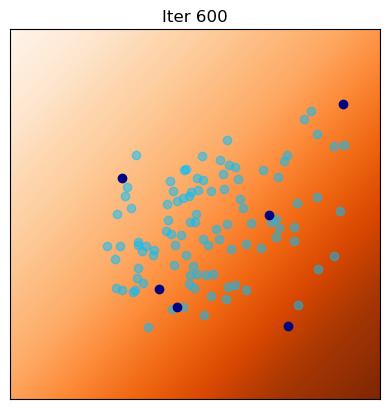

[700/1000], -0.003500


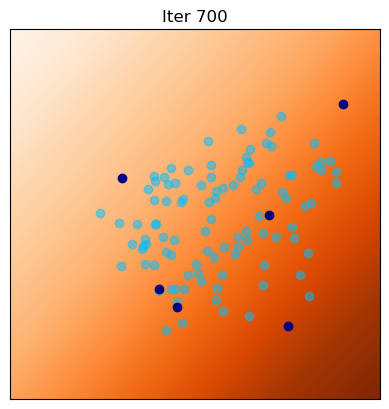

[800/1000], -0.004519


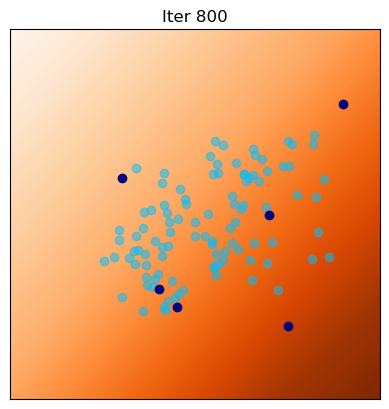

[900/1000], -0.004000


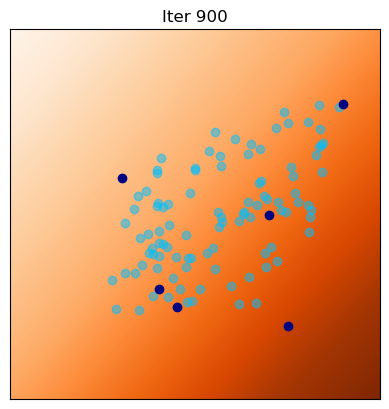

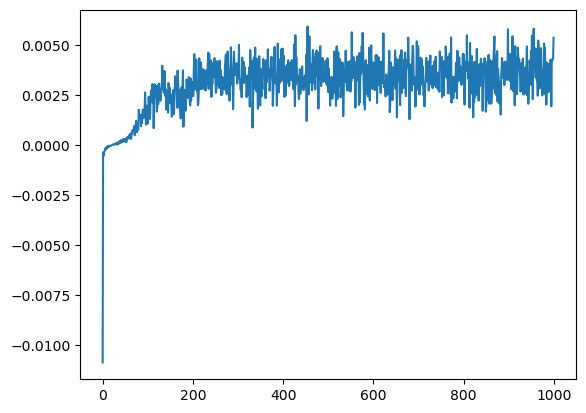

In [6]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# fix one generator
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000

clip_value = 0.1

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0, niterD):

    ### UPDATE OF D ###
    optimD.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x = G(z).detach()

    Dloss =  torch.mean(D(x)) - torch.mean(D(y))

    Dloss.backward()
    optimD.step()

    ### Weight Clipping ###
    for p in D.parameters():
        p.data.clamp_(-clip_value, clip_value)

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if iter % iter_display == 0:
        print("[%d/%d], %f" % (iter, niterD, Dlosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = "Iter " + str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap="Oranges", extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
        plt.title(strtitle)
        plt.show()

plt.plot(Dlosses)
plt.show()

## Estimate the Lipschitz constant of the discriminator

The following function computes a lower bound of the Lipschitz constant of $D$ on points that are interpolated between $x$ and $y$.

NB: If $x$ and $y$ do not have the same number of points, we discard the last points.
In comment, we give an alternative code that allows to compute all segments $[x_i, y_j]$ (but it is, of course, slower that just computing segments $[x_i, y_i]$).

In [7]:
def lipconstant(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(
        outputs=Di,
        inputs=interp,
        grad_outputs=gradout,
        create_graph=True,
        retain_graph=True,
    )[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

    # Return gradient penalty
    return torch.mean(gradients_norm)


#     # Calculate interpolation
#     b = x.shape[0]
#     n = y.shape[0]
#     alpha = torch.rand((b,n,1),device=device)
#     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
#     interp.requires_grad_()


QUESTION: Use this function to examine the Lipschitz constant of the final discriminator obtained above with weight clipping.


In [8]:
print(f"""Lipschitz constant of the final discriminator: {lipconstant(D, x, y)}""")
print(f"""L < 1: {lipconstant(D, x, y) < 1}""")

Lipschitz constant of the final discriminator: 0.06384287774562836
L < 1: True


## Gradient Penalty

QUESTION: Implement a function computing the gradient penalty of a discriminator $D$ on points $X$ that are randomly interpolated between $x$ and $y$:
$$ GP(D) = \mathbb{E}\left[ \Big(\|\nabla D(X)\| - 1 \Big)^2 \right] .$$
In pratice you will use
$$\|\nabla D(X)\| \approx \sqrt{\|\nabla D (X)\|_2^2 + 10^{-12} } $$
to avoid numerical instability.

In [9]:
def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n
    # compute interpolated points
    alpha = torch.rand((b, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    #     # Calculate interpolation
    #     b = x.shape[0]
    #     n = y.shape[0]
    #     alpha = torch.rand((b,n,1),device=device)
    #     interp = (alpha * y[None,:,:] + (1 - alpha) * x[:,None,:]).flatten(end_dim=1)
    #     interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(
        outputs=Di,
        inputs=interp,
        grad_outputs=gradout,
        create_graph=True,
        retain_graph=True,
    )[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients**2, dim=1) + 1e-12)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()


#     return ((gradients_norm - 1) ** 2*(gradients_norm>1)).mean()

print(gradient_penalty(D, x, y))

tensor(0.8765, device='cuda:0', grad_fn=<MeanBackward0>)


## Discriminator training with Gradient Penalty

QUESTION: Complete the following code at the blocks ###...###.

Adjust the weight of the gradient penalty (parameter `gpw`) to get a Lipschitz constant $\approx 1$.

[0/1000], Dloss=5.6300, Lip(D)=0.2618


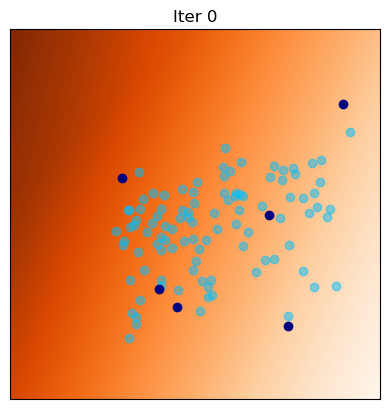

[100/1000], Dloss=0.0287, Lip(D)=0.9869


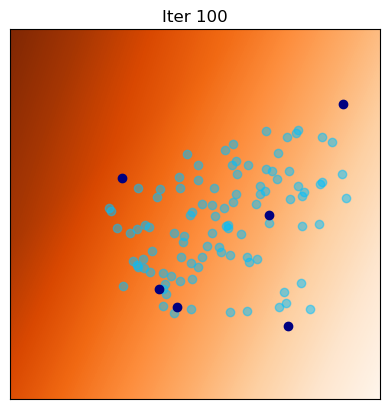

[200/1000], Dloss=0.0395, Lip(D)=0.9971


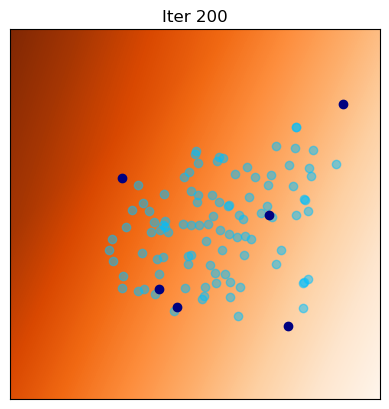

[300/1000], Dloss=0.0208, Lip(D)=0.9981


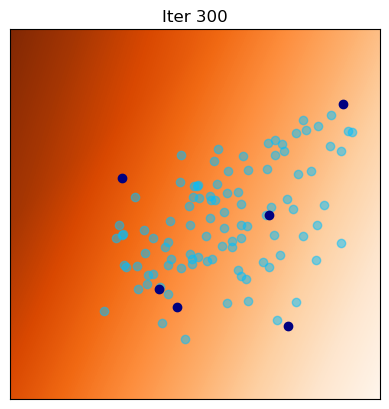

[400/1000], Dloss=0.0587, Lip(D)=0.9990


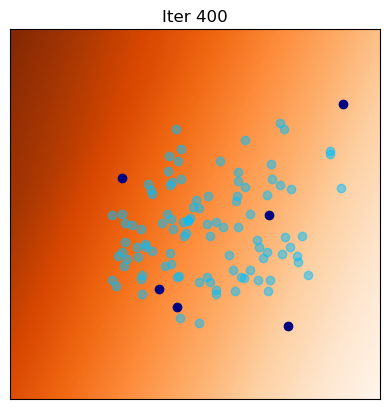

[500/1000], Dloss=0.0365, Lip(D)=0.9984


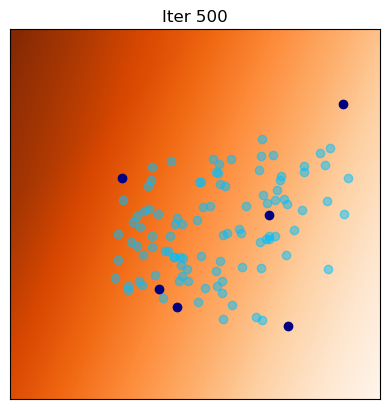

[600/1000], Dloss=0.0387, Lip(D)=0.9973


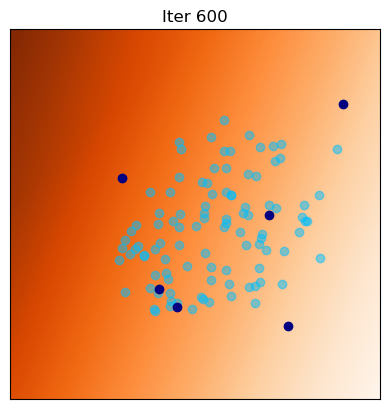

[700/1000], Dloss=0.0358, Lip(D)=0.9959


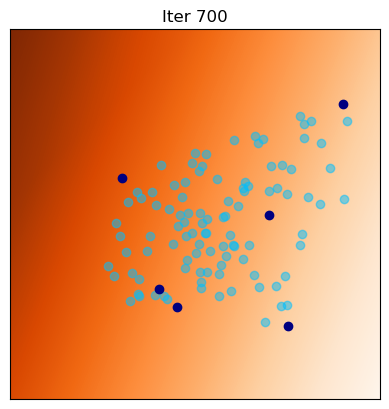

[800/1000], Dloss=0.0471, Lip(D)=0.9961


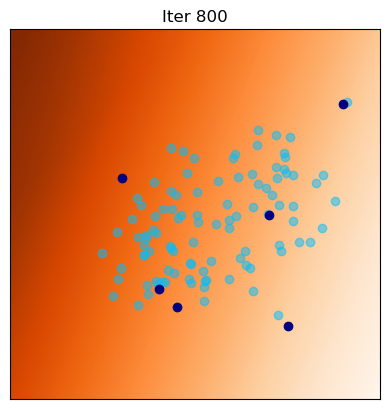

[900/1000], Dloss=0.0627, Lip(D)=0.9816


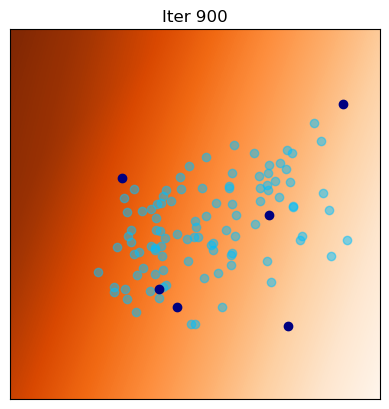

Final estimated Lipschitz constant =  0.9924706816673279


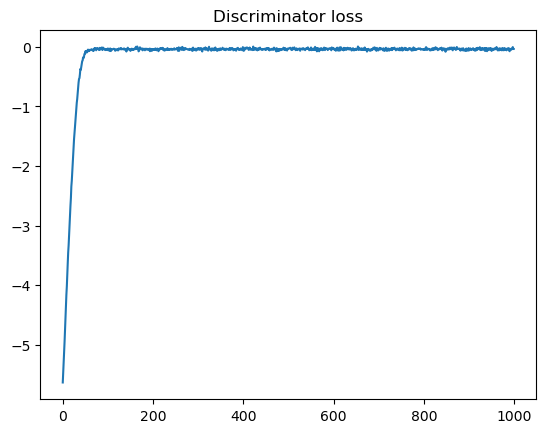

In [10]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000
gpw = 10 # parameter for gradient penalty

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

iter_display = 100  # display current configuration each iter_display iteration

# Lists to keep track of progress
Dlosses = []

for iter in range(0, niterD):
    ### UPDATE OF D ###
    optimD.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x = G(z).detach()

    Dloss = torch.mean(D(x)) + gpw * gradient_penalty(D, x, y) - torch.mean(D(y))

    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if iter % iter_display == 0:
        print(
            "[%d/%d], Dloss=%.4f, Lip(D)=%.4f"
            % (iter, niterD, Dlosst, lipconstant(D, x, y).item())
        )
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = "Iter " + str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap="Oranges", extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
        plt.title(strtitle)
        plt.show()

print("Final estimated Lipschitz constant = ", lipconstant(D, x, y).item())

plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title("Discriminator loss")
plt.show()

## WGAN-GP training

QUESTION: Complete the following code in order to train simultaneously the generator and discriminator.

You will alternate `niterD` iterations on the discriminator and `niterG` iterations of the discriminator.

**ANSWER**:

[1/100] 	Loss_D: -0.1572	Loss_G: 0.1388	Lip(D)=1.4872
[2/100] 	Loss_D: -0.0995	Loss_G: 0.4354	Lip(D)=1.4090
[3/100] 	Loss_D: -0.1307	Loss_G: 0.5629	Lip(D)=1.4887
[4/100] 	Loss_D: -0.1342	Loss_G: 0.3948	Lip(D)=1.3811
[5/100] 	Loss_D: -0.1437	Loss_G: 0.0848	Lip(D)=1.4109


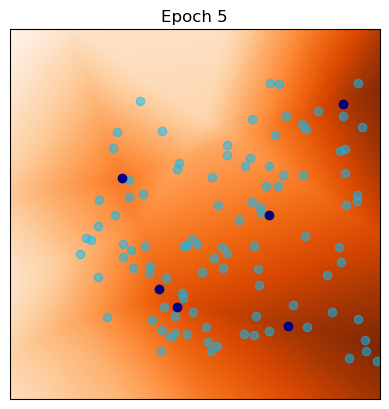

[6/100] 	Loss_D: -0.0958	Loss_G: 0.6758	Lip(D)=1.2776
[7/100] 	Loss_D: -0.1060	Loss_G: 0.7795	Lip(D)=1.2002
[8/100] 	Loss_D: -0.1379	Loss_G: 0.5944	Lip(D)=1.1717
[9/100] 	Loss_D: -0.0972	Loss_G: 0.7964	Lip(D)=1.4094
[10/100] 	Loss_D: -0.0801	Loss_G: 1.2613	Lip(D)=1.2552


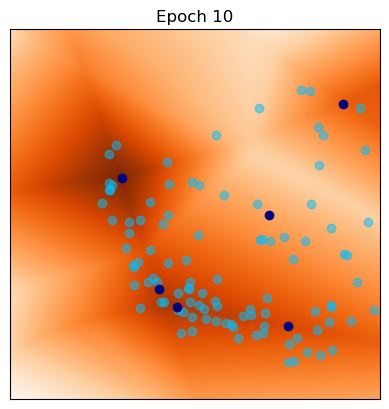

[11/100] 	Loss_D: -0.0580	Loss_G: 1.1704	Lip(D)=1.4527
[12/100] 	Loss_D: -0.0667	Loss_G: 0.7957	Lip(D)=1.2741
[13/100] 	Loss_D: -0.0890	Loss_G: 0.7266	Lip(D)=1.3327
[14/100] 	Loss_D: -0.0615	Loss_G: 1.0414	Lip(D)=1.2569
[15/100] 	Loss_D: -0.0550	Loss_G: 0.4227	Lip(D)=1.2052


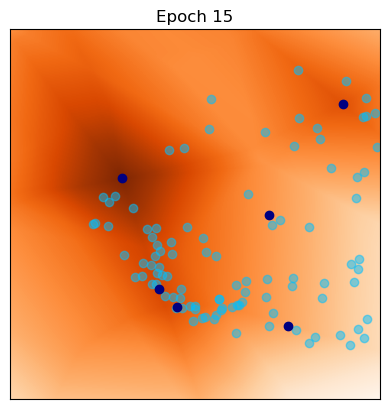

[16/100] 	Loss_D: -0.0729	Loss_G: -0.2738	Lip(D)=1.1780
[17/100] 	Loss_D: -0.1069	Loss_G: -0.9047	Lip(D)=1.3943
[18/100] 	Loss_D: -0.0834	Loss_G: -1.6786	Lip(D)=1.4424
[19/100] 	Loss_D: -0.0940	Loss_G: -2.2243	Lip(D)=1.2721
[20/100] 	Loss_D: -0.0476	Loss_G: -2.3209	Lip(D)=1.2502


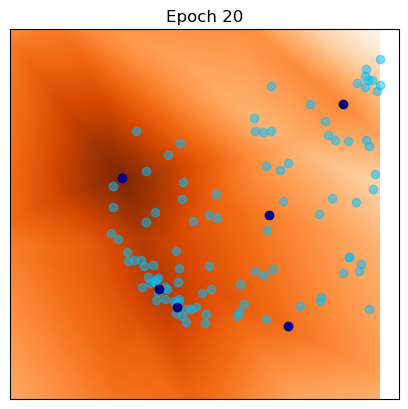

[21/100] 	Loss_D: -0.0340	Loss_G: -2.2216	Lip(D)=1.1825
[22/100] 	Loss_D: -0.0604	Loss_G: -2.0064	Lip(D)=1.1746
[23/100] 	Loss_D: -0.1127	Loss_G: -2.3411	Lip(D)=1.1060
[24/100] 	Loss_D: -0.1006	Loss_G: -2.7710	Lip(D)=1.4240
[25/100] 	Loss_D: -0.0638	Loss_G: -2.6673	Lip(D)=1.3687


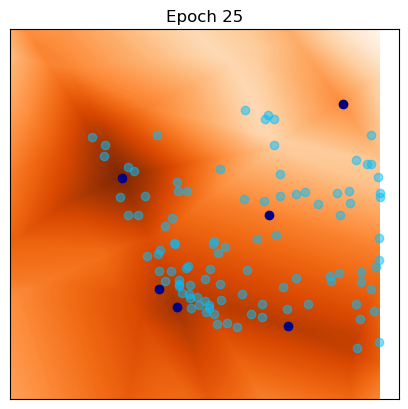

[26/100] 	Loss_D: -0.1059	Loss_G: -2.4589	Lip(D)=1.4088
[27/100] 	Loss_D: -0.1054	Loss_G: -2.7680	Lip(D)=1.1791
[28/100] 	Loss_D: -0.1620	Loss_G: -3.3492	Lip(D)=1.3011
[29/100] 	Loss_D: -0.1520	Loss_G: -4.8049	Lip(D)=1.3562
[30/100] 	Loss_D: -0.1542	Loss_G: -6.4612	Lip(D)=1.4693


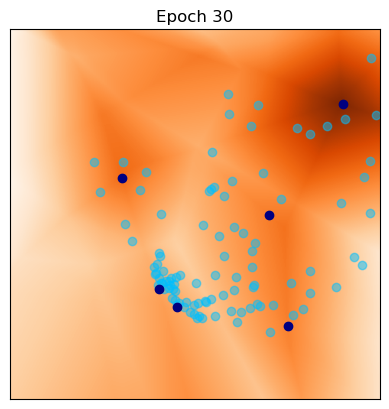

[31/100] 	Loss_D: -0.1073	Loss_G: -7.5822	Lip(D)=1.9119
[32/100] 	Loss_D: -0.1135	Loss_G: -7.9708	Lip(D)=1.3878
[33/100] 	Loss_D: -0.1185	Loss_G: -8.1029	Lip(D)=1.3398
[34/100] 	Loss_D: -0.1017	Loss_G: -8.4066	Lip(D)=1.3810
[35/100] 	Loss_D: -0.1159	Loss_G: -8.8120	Lip(D)=1.3035


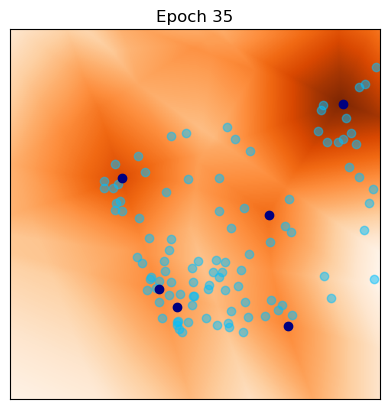

[36/100] 	Loss_D: -0.0987	Loss_G: -9.4546	Lip(D)=1.5930
[37/100] 	Loss_D: -0.1214	Loss_G: -10.0084	Lip(D)=1.6886
[38/100] 	Loss_D: -0.0895	Loss_G: -10.0937	Lip(D)=1.3131
[39/100] 	Loss_D: -0.0989	Loss_G: -10.1576	Lip(D)=1.5993
[40/100] 	Loss_D: -0.0919	Loss_G: -10.3023	Lip(D)=1.6213


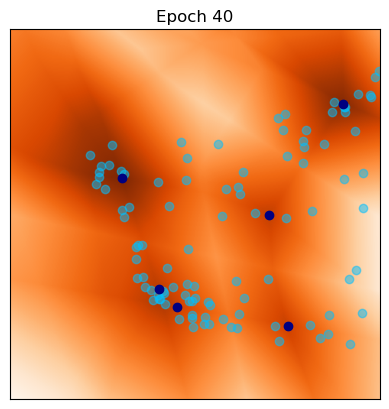

[41/100] 	Loss_D: -0.1418	Loss_G: -10.4998	Lip(D)=1.4205
[42/100] 	Loss_D: -0.0924	Loss_G: -10.8484	Lip(D)=1.3882
[43/100] 	Loss_D: -0.0721	Loss_G: -11.0936	Lip(D)=1.5506
[44/100] 	Loss_D: -0.1042	Loss_G: -11.2505	Lip(D)=1.4265
[45/100] 	Loss_D: -0.1088	Loss_G: -11.4205	Lip(D)=1.1227


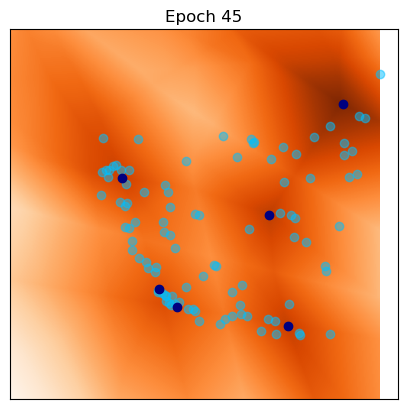

[46/100] 	Loss_D: -0.1133	Loss_G: -11.7458	Lip(D)=1.5729
[47/100] 	Loss_D: -0.1040	Loss_G: -11.8283	Lip(D)=1.5158
[48/100] 	Loss_D: -0.0916	Loss_G: -12.3117	Lip(D)=1.3491
[49/100] 	Loss_D: -0.1064	Loss_G: -12.5193	Lip(D)=1.3783
[50/100] 	Loss_D: -0.0849	Loss_G: -12.8133	Lip(D)=1.5391


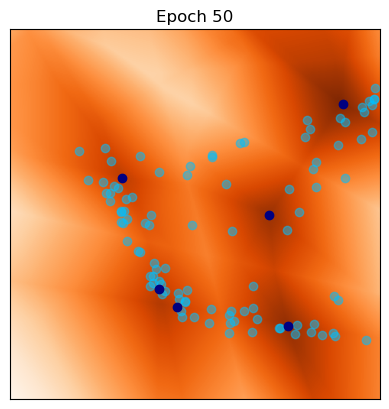

[51/100] 	Loss_D: -0.0976	Loss_G: -13.3396	Lip(D)=1.3914
[52/100] 	Loss_D: -0.0976	Loss_G: -13.5389	Lip(D)=1.1638
[53/100] 	Loss_D: -0.0843	Loss_G: -13.5431	Lip(D)=1.3230
[54/100] 	Loss_D: -0.0854	Loss_G: -13.7502	Lip(D)=1.3553
[55/100] 	Loss_D: -0.1004	Loss_G: -14.5182	Lip(D)=1.4347


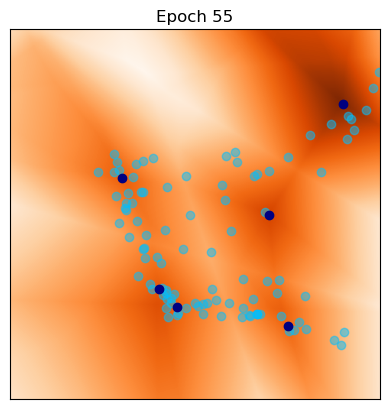

[56/100] 	Loss_D: -0.0846	Loss_G: -14.6101	Lip(D)=1.2632
[57/100] 	Loss_D: -0.0818	Loss_G: -14.8107	Lip(D)=1.2761
[58/100] 	Loss_D: -0.0739	Loss_G: -15.0223	Lip(D)=1.3083
[59/100] 	Loss_D: -0.1192	Loss_G: -15.1013	Lip(D)=1.1493
[60/100] 	Loss_D: -0.1022	Loss_G: -16.2935	Lip(D)=1.3172


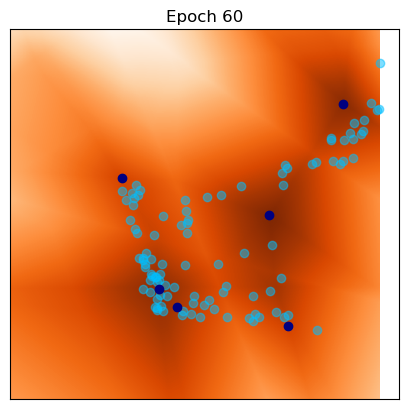

[61/100] 	Loss_D: -0.0587	Loss_G: -15.5817	Lip(D)=1.3720
[62/100] 	Loss_D: -0.1186	Loss_G: -16.3330	Lip(D)=1.6260
[63/100] 	Loss_D: -0.0887	Loss_G: -16.7694	Lip(D)=1.2234
[64/100] 	Loss_D: -0.1183	Loss_G: -17.3666	Lip(D)=1.5564
[65/100] 	Loss_D: -0.0489	Loss_G: -16.9242	Lip(D)=1.2208


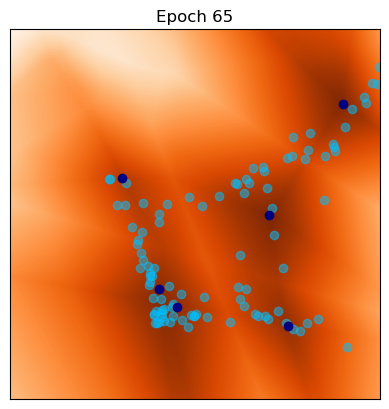

[66/100] 	Loss_D: -0.1234	Loss_G: -16.8329	Lip(D)=1.3115
[67/100] 	Loss_D: -0.1313	Loss_G: -18.0052	Lip(D)=1.2864
[68/100] 	Loss_D: -0.1017	Loss_G: -16.8814	Lip(D)=1.2508
[69/100] 	Loss_D: -0.1096	Loss_G: -18.6766	Lip(D)=1.1682
[70/100] 	Loss_D: -0.0938	Loss_G: -20.5484	Lip(D)=1.1952


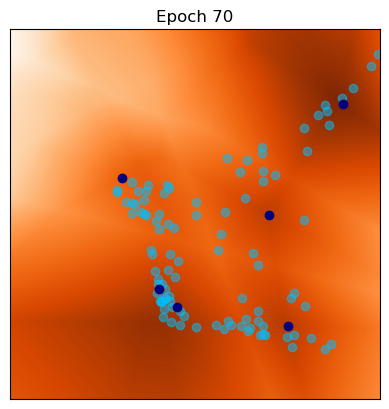

[71/100] 	Loss_D: -0.0988	Loss_G: -19.3009	Lip(D)=1.2134
[72/100] 	Loss_D: -0.0900	Loss_G: -19.6518	Lip(D)=1.4177
[73/100] 	Loss_D: -0.1039	Loss_G: -20.4948	Lip(D)=1.4907
[74/100] 	Loss_D: -0.0688	Loss_G: -21.8094	Lip(D)=1.5193
[75/100] 	Loss_D: -0.1299	Loss_G: -22.0515	Lip(D)=1.3874


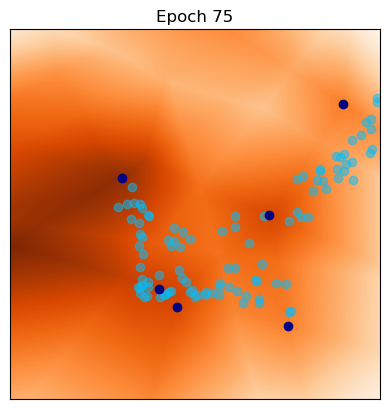

[76/100] 	Loss_D: -0.1359	Loss_G: -22.7006	Lip(D)=1.4434
[77/100] 	Loss_D: -0.1101	Loss_G: -22.6689	Lip(D)=1.6957
[78/100] 	Loss_D: -0.1107	Loss_G: -22.9102	Lip(D)=1.4895
[79/100] 	Loss_D: -0.1157	Loss_G: -23.2339	Lip(D)=1.3589
[80/100] 	Loss_D: -0.1153	Loss_G: -22.6546	Lip(D)=1.2894


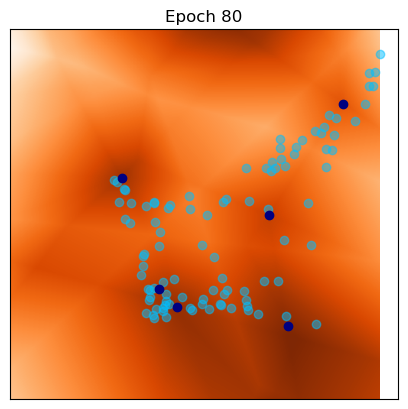

[81/100] 	Loss_D: -0.1080	Loss_G: -22.0618	Lip(D)=1.3411
[82/100] 	Loss_D: -0.0957	Loss_G: -23.0231	Lip(D)=1.5058
[83/100] 	Loss_D: -0.0531	Loss_G: -23.4833	Lip(D)=1.4151
[84/100] 	Loss_D: -0.0972	Loss_G: -22.8877	Lip(D)=1.3948
[85/100] 	Loss_D: -0.0618	Loss_G: -22.5125	Lip(D)=1.3085


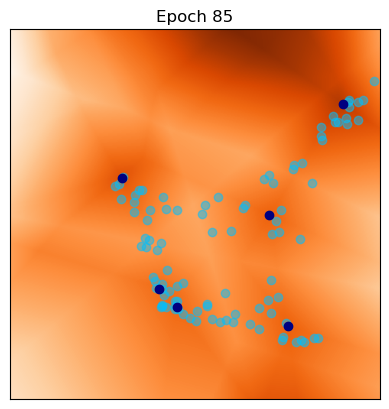

[86/100] 	Loss_D: -0.0961	Loss_G: -22.3910	Lip(D)=1.3392
[87/100] 	Loss_D: -0.0909	Loss_G: -22.4102	Lip(D)=1.2414
[88/100] 	Loss_D: -0.0972	Loss_G: -22.6548	Lip(D)=1.3542
[89/100] 	Loss_D: -0.0818	Loss_G: -22.5599	Lip(D)=1.3007
[90/100] 	Loss_D: -0.0878	Loss_G: -22.9223	Lip(D)=1.2213


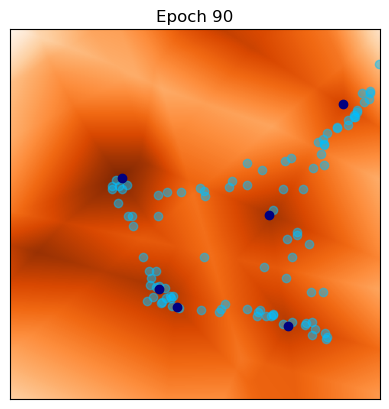

[91/100] 	Loss_D: -0.1017	Loss_G: -23.6169	Lip(D)=1.1731
[92/100] 	Loss_D: -0.0693	Loss_G: -23.9555	Lip(D)=1.2672
[93/100] 	Loss_D: -0.0431	Loss_G: -24.1708	Lip(D)=1.1914
[94/100] 	Loss_D: -0.0867	Loss_G: -24.2684	Lip(D)=1.3948
[95/100] 	Loss_D: -0.0613	Loss_G: -25.0574	Lip(D)=1.3497


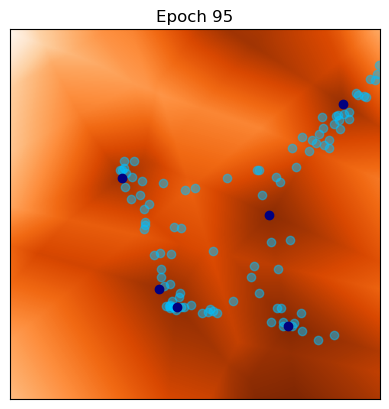

[96/100] 	Loss_D: -0.0921	Loss_G: -25.2536	Lip(D)=1.1465
[97/100] 	Loss_D: -0.0904	Loss_G: -25.6464	Lip(D)=1.2154
[98/100] 	Loss_D: -0.0734	Loss_G: -26.1687	Lip(D)=1.5780
[99/100] 	Loss_D: -0.0789	Loss_G: -26.5932	Lip(D)=1.4020


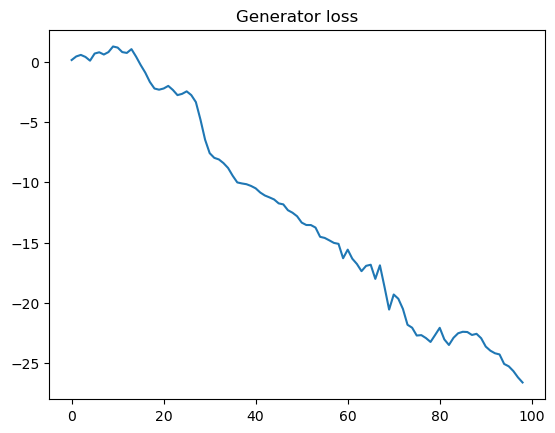

<All keys matched successfully>

In [11]:
## parameters for training
n_epochs = 100
niterD = 1000
niterG = 10
gpw = 0.1

lr = 0.002  # learning rate for generator
lrdisc = 0.002  # learning rate for discriminator
beta_1 = 0.5
beta_2 = 0.999

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))


Glosses = []
Dlosses = []

iter_display = 5

# Main loop
for epoch in range(1, n_epochs):

    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0, niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z).detach()

        Dloss = torch.mean(D(x)) + gpw * gradient_penalty(D, x, y) - torch.mean(D(y))

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0, niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z)

        Gloss = -torch.mean(D(x))

        Gloss.backward()
        optimG.step()

    # Output training stats
    print(
        "[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f\tLip(D)=%.4f"
        % (epoch, n_epochs, Dloss.item(), Gloss.item(), lipconstant(D, x, y).item())
    )
    Glosses.append(Gloss.item())
    Dlosses.append(Dloss.item())

    if epoch % iter_display == 0:
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = "Epoch " + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap="Oranges", extent=extent)
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
        plt.title(strtitle)
        plt.show()

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title("Generator loss")
plt.show()

# Save final generator for later use
wgan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
wgan.load_state_dict(G.state_dict())

## Sensitivy to hyper-parameters

QUESTION: Repeat the WGAN learning experiment, by changing the parameters of the optimization (learning rates, number of updates of D and G, etc).

From your experiments, can you draw a few recommendations for stable training?

**ANSWER**:

Here are some recommendations for stable WGAN training:

1. Adjust learning rates (start low, adjust based on performance).
2. Balance the number of updates for discriminator and generator.
3. Experiment with batch sizes for stability and convergence speed.
4. Possibly apply normalization techniques like batch normalization.
5. Consider regularization methods like weight decay or dropout.
6. Monitor training progress and implement early stopping if necessary.

## Train the generator only

QUESTION: For a fixed discriminator, optimize only the generator only. Can you explain what is happening then?

**ANSWER**:

When one optimizes only the generator while keeping the discriminator fixed in a Generative Adversarial Network (GAN), one risks encountering mode collapse due to limited diversity in generated samples and loss divergence, leading to overfitting. Furthermore, the discriminator's discriminative power may decrease over time, hindering overall GAN performance, as the generator lacks the crucial feedback needed for effective learning. This approach limits the generator's learning process and can result in suboptimal performance and training instability compared to joint optimization of both components.

[0/10], Gloss=0.6696


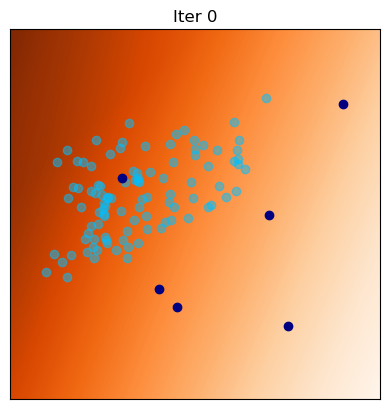

[3/10], Gloss=0.5465


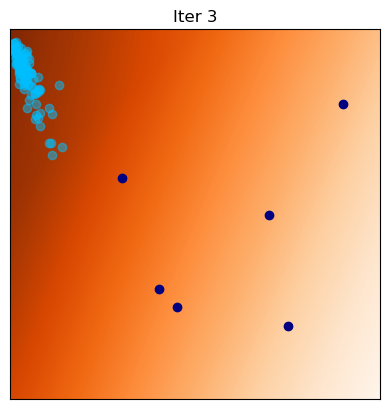

[6/10], Gloss=0.5110


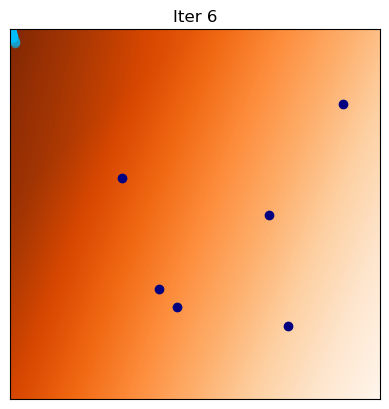

[9/10], Gloss=0.5086


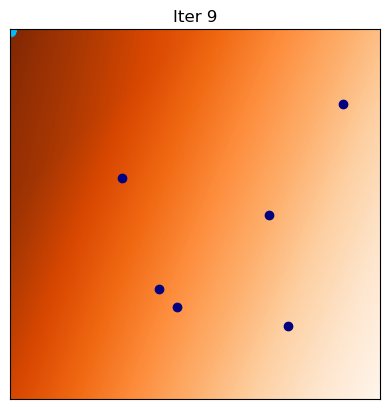

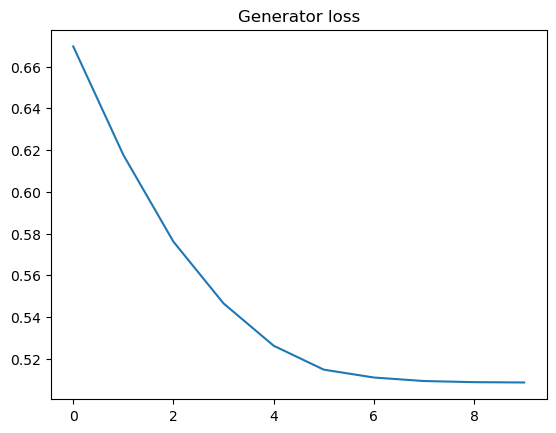

In [13]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

# parameters for training
lr = 0.05
niterG = 10

optimG = optim.Adam(G.parameters(), lr=lr)

iter_display = 3  # display current configuration each iter_display iteration

# Lists to keep track of progress
Glosses = []

for iter in range(0, niterG):
    ### UPDATE OF G ###
    optimG.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x = G(z)

    Gloss = torch.mean(-D(x))

    Gloss.backward()
    optimG.step()

    ### SAVE LOSS ###
    Glosst = Gloss.item()
    Glosses.append(Glosst)

    if iter % iter_display == 0:
        print("[%d/%d], Gloss=%.4f" % (iter, niterG, Glosst))
        Dxgrid = D(xgrid).detach().cpu().numpy().reshape(nr, nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = "Iter " + str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap="Oranges", extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
        plt.title(strtitle)
        plt.show()

plt.figure(dpi=100)
plt.plot(Glosses)
plt.title("Generator loss")
plt.show()

<br/><br/><br/><br/>

# BONUS Exercise (to do at home) : Learn a standard GAN

## Define Loss for GAN training

For stable GAN training uses the Binary cross-entropy loss which takes labeled data as input.

The data points $y$ should correspond to values $\approx 1$, whereas fake points $x$ should get values $\approx 0$.

We also introduce the sigmoid function. for displaying purpose: for GAN training, the discriminator values in $[0,1]$ will be obtained by applying after $D$.

In [14]:
# pos_weight is used to account for the imbalance in classes
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([b/n]).to(device))
V1 = torch.full((n, 1), 1.0, dtype=torch.float, device=device)
V0 = torch.full((b, 1), 0.0, dtype=torch.float, device=device)

sig = nn.Sigmoid()

## Train the discriminator for a fixed generator

QUESTION: Complete the following code at the blocks ###...###

[0/1000], 1.418812


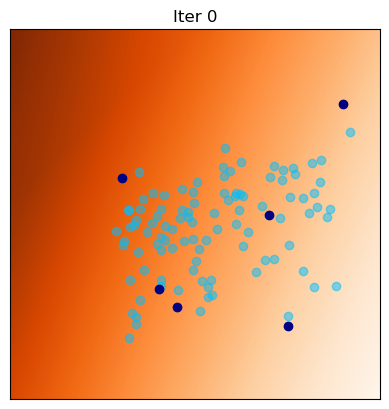

[100/1000], 1.301992


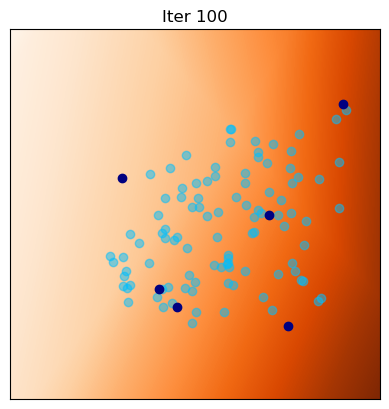

[200/1000], 1.280947


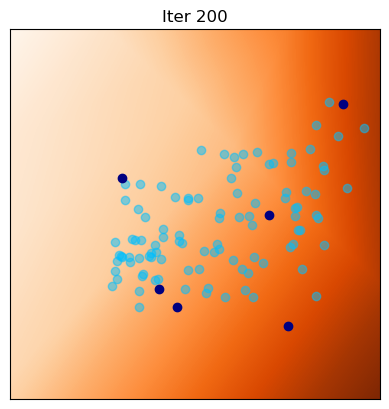

[300/1000], 1.221008


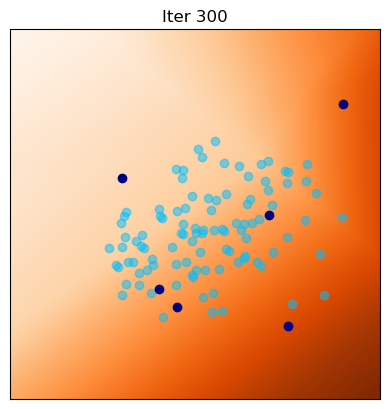

[400/1000], 1.162755


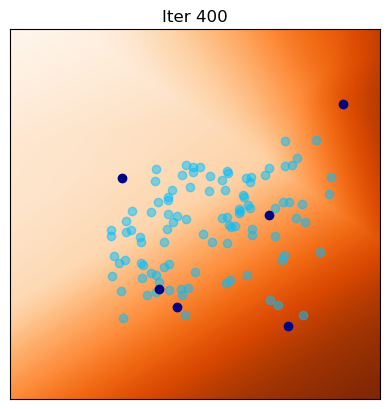

[500/1000], 1.181991


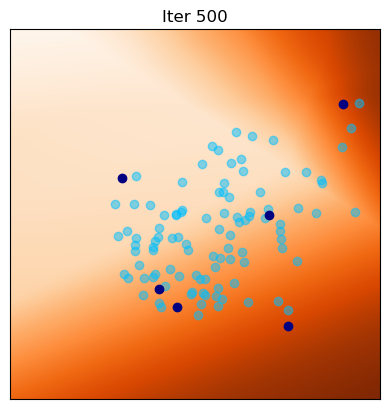

[600/1000], 1.101644


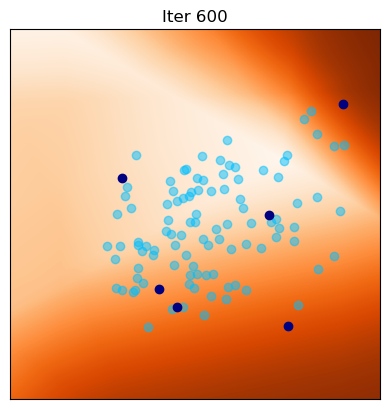

[700/1000], 1.007336


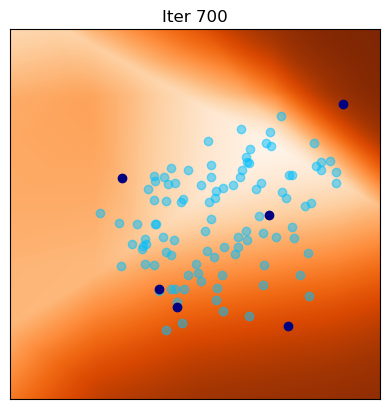

[800/1000], 0.946521


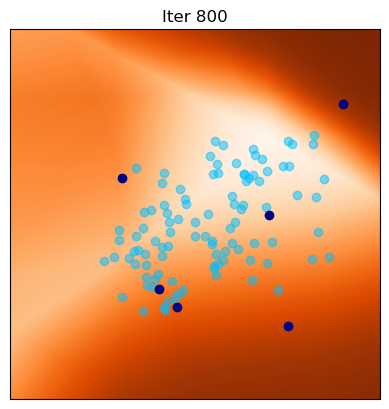

[900/1000], 0.921994


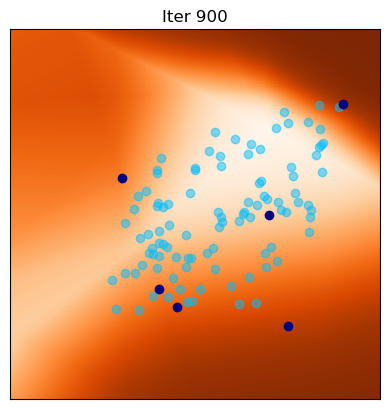

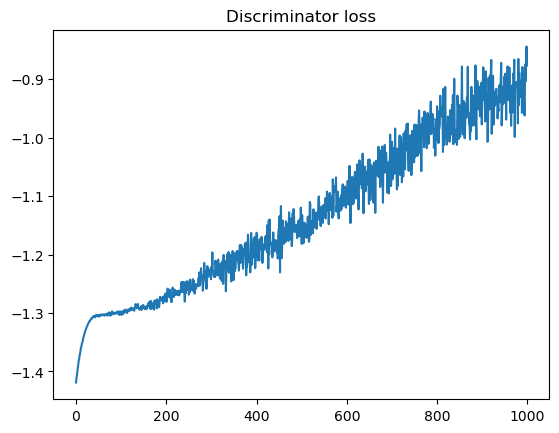

In [15]:
torch.manual_seed(1)  # initialize random seed for reproducibility

# parameters for discriminator optimization
lrdisc = 0.002
beta_1 = 0.5
beta_2 = 0.999
niterD = 1000

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
D = Discriminator(n_in=d, n_hid=10).to(device)

optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, 0.999))

iter_display = 100  # display current configuration each iter_display iteration

Dlosses = []

for iter in range(0, niterD):
    ### UPDATE OF D ###
    optimD.zero_grad()

    z = torch.randn(b, n_in, device=device)
    x = G(z).detach()

    inp = torch.cat((D(y), D(x)))
    target = torch.cat((V1, V0))

    Dloss = criterion(inp, target)
    # Equivalently:
    # Dloss = - torch.mean(torch.log(sig(D(y)))) - torch.mean(torch.log(1 - sig(D(x))))

    Dloss.backward()
    optimD.step()

    ### SAVE LOSS ###
    Dlosst = Dloss.item()
    Dlosses.append(-Dlosst)

    if iter % iter_display == 0:
        print("[%d/%d], %f" % (iter, niterD, Dlosst))
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr, nc)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = "Iter " + str(iter)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap="Oranges", extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
        plt.title(strtitle)
        plt.show()


### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Dlosses)
plt.title("Discriminator loss")
plt.show()

## Train both the Generator and Discriminator

[0/100] 	Loss_D: 1.3000	Loss_G: -0.6984


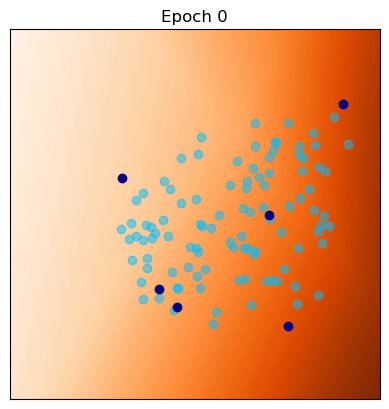

[1/100] 	Loss_D: 1.2872	Loss_G: -0.6795
[2/100] 	Loss_D: 1.2345	Loss_G: -0.6771
[3/100] 	Loss_D: 1.2465	Loss_G: -0.6009
[4/100] 	Loss_D: 1.2023	Loss_G: -0.5971
[5/100] 	Loss_D: 1.1355	Loss_G: -0.6193
[6/100] 	Loss_D: 1.1462	Loss_G: -0.5075
[7/100] 	Loss_D: 1.0983	Loss_G: -0.6192
[8/100] 	Loss_D: 1.0902	Loss_G: -0.6175
[9/100] 	Loss_D: 1.0815	Loss_G: -0.5244
[10/100] 	Loss_D: 1.0764	Loss_G: -0.5424


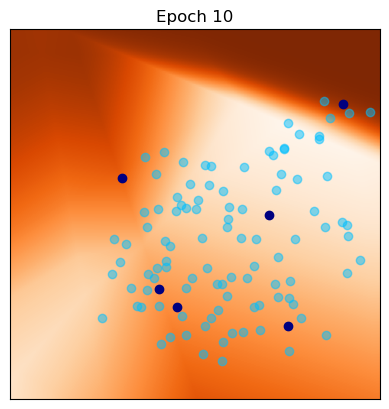

[11/100] 	Loss_D: 1.0451	Loss_G: -0.5398
[12/100] 	Loss_D: 1.0727	Loss_G: -0.5747
[13/100] 	Loss_D: 1.0751	Loss_G: -0.6494
[14/100] 	Loss_D: 1.0407	Loss_G: -0.5825
[15/100] 	Loss_D: 1.0692	Loss_G: -0.6433
[16/100] 	Loss_D: 1.0965	Loss_G: -0.6354
[17/100] 	Loss_D: 1.1116	Loss_G: -0.6150
[18/100] 	Loss_D: 1.1410	Loss_G: -0.7188
[19/100] 	Loss_D: 1.1781	Loss_G: -0.5527
[20/100] 	Loss_D: 1.2127	Loss_G: -0.6111


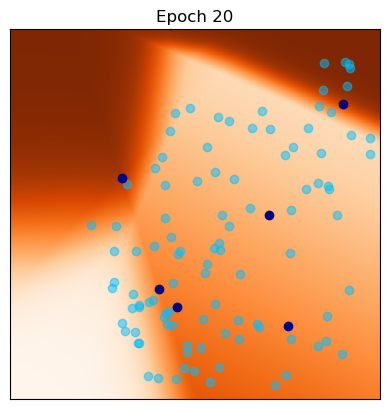

[21/100] 	Loss_D: 1.1963	Loss_G: -0.7278
[22/100] 	Loss_D: 1.0727	Loss_G: -0.6388
[23/100] 	Loss_D: 1.1645	Loss_G: -0.6140
[24/100] 	Loss_D: 1.2919	Loss_G: -0.5339
[25/100] 	Loss_D: 1.1018	Loss_G: -0.6234
[26/100] 	Loss_D: 1.1280	Loss_G: -0.7071
[27/100] 	Loss_D: 1.1592	Loss_G: -0.5934
[28/100] 	Loss_D: 1.1367	Loss_G: -0.5484
[29/100] 	Loss_D: 1.1528	Loss_G: -0.6655
[30/100] 	Loss_D: 1.1691	Loss_G: -0.6580


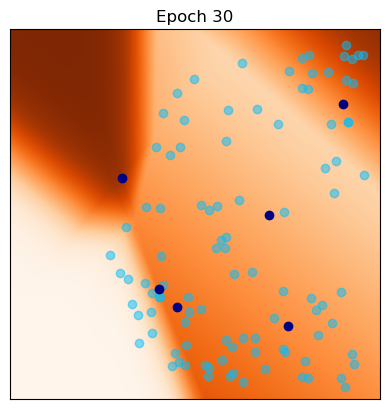

[31/100] 	Loss_D: 1.1189	Loss_G: -0.6529
[32/100] 	Loss_D: 1.1229	Loss_G: -0.6231
[33/100] 	Loss_D: 1.1632	Loss_G: -0.6533
[34/100] 	Loss_D: 1.1880	Loss_G: -0.6328
[35/100] 	Loss_D: 1.1315	Loss_G: -0.5893
[36/100] 	Loss_D: 1.1635	Loss_G: -0.5351
[37/100] 	Loss_D: 1.1317	Loss_G: -0.5911
[38/100] 	Loss_D: 1.1542	Loss_G: -0.5463
[39/100] 	Loss_D: 1.1453	Loss_G: -0.6021
[40/100] 	Loss_D: 1.1111	Loss_G: -0.6597


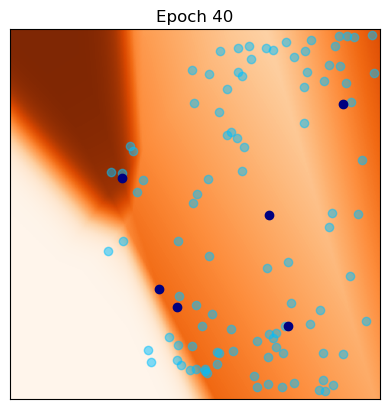

[41/100] 	Loss_D: 1.1641	Loss_G: -0.5841
[42/100] 	Loss_D: 1.1685	Loss_G: -0.5957
[43/100] 	Loss_D: 1.1043	Loss_G: -0.6927
[44/100] 	Loss_D: 1.1367	Loss_G: -0.6300
[45/100] 	Loss_D: 1.1528	Loss_G: -0.5167
[46/100] 	Loss_D: 1.1718	Loss_G: -0.5289
[47/100] 	Loss_D: 1.2122	Loss_G: -0.5890
[48/100] 	Loss_D: 1.1687	Loss_G: -0.6000
[49/100] 	Loss_D: 1.1190	Loss_G: -0.6383
[50/100] 	Loss_D: 1.1577	Loss_G: -0.5552


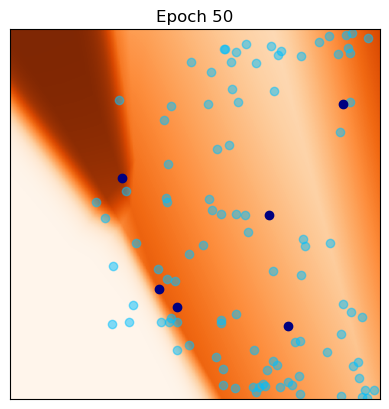

[51/100] 	Loss_D: 1.1654	Loss_G: -0.5373
[52/100] 	Loss_D: 1.2231	Loss_G: -0.5905
[53/100] 	Loss_D: 1.1658	Loss_G: -0.5608
[54/100] 	Loss_D: 1.0931	Loss_G: -0.6691
[55/100] 	Loss_D: 1.1040	Loss_G: -0.6160
[56/100] 	Loss_D: 1.0497	Loss_G: -0.5810
[57/100] 	Loss_D: 1.0902	Loss_G: -0.5389
[58/100] 	Loss_D: 1.0306	Loss_G: -0.5110
[59/100] 	Loss_D: 0.9990	Loss_G: -0.4863
[60/100] 	Loss_D: 0.9188	Loss_G: -0.6502


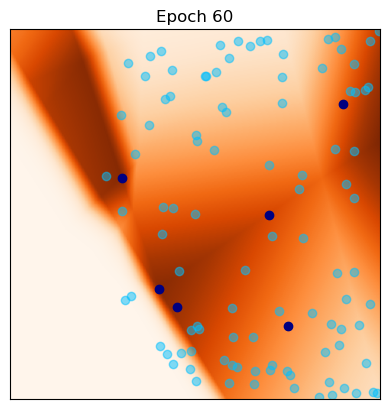

[61/100] 	Loss_D: 0.9753	Loss_G: -0.4815
[62/100] 	Loss_D: 0.9140	Loss_G: -0.5473
[63/100] 	Loss_D: 0.8381	Loss_G: -0.4108
[64/100] 	Loss_D: 0.8025	Loss_G: -0.4214
[65/100] 	Loss_D: 0.9139	Loss_G: -0.4282
[66/100] 	Loss_D: 0.8323	Loss_G: -0.4512
[67/100] 	Loss_D: 0.8905	Loss_G: -0.4286
[68/100] 	Loss_D: 0.7730	Loss_G: -0.4910
[69/100] 	Loss_D: 0.7739	Loss_G: -0.3835
[70/100] 	Loss_D: 0.7597	Loss_G: -0.4332


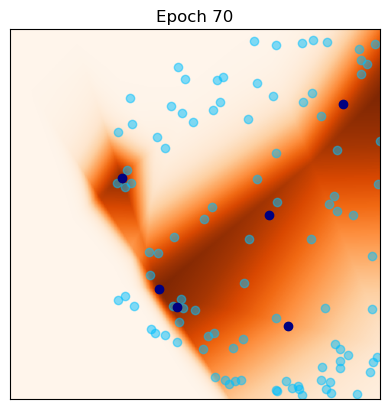

[71/100] 	Loss_D: 0.7547	Loss_G: -0.5507
[72/100] 	Loss_D: 0.7813	Loss_G: -0.4987
[73/100] 	Loss_D: 0.7793	Loss_G: -0.3854
[74/100] 	Loss_D: 0.6997	Loss_G: -0.4240
[75/100] 	Loss_D: 0.7862	Loss_G: -0.3406
[76/100] 	Loss_D: 0.7783	Loss_G: -0.4553
[77/100] 	Loss_D: 0.7699	Loss_G: -0.4618
[78/100] 	Loss_D: 0.7295	Loss_G: -0.3891
[79/100] 	Loss_D: 0.8370	Loss_G: -0.3460
[80/100] 	Loss_D: 0.7407	Loss_G: -0.5300


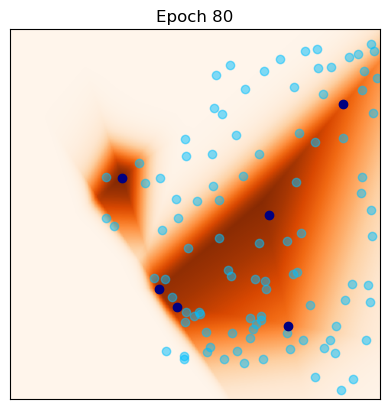

[81/100] 	Loss_D: 0.7200	Loss_G: -0.4563
[82/100] 	Loss_D: 0.7630	Loss_G: -0.4340
[83/100] 	Loss_D: 0.7831	Loss_G: -0.3978
[84/100] 	Loss_D: 0.7638	Loss_G: -0.4135
[85/100] 	Loss_D: 0.8150	Loss_G: -0.4922
[86/100] 	Loss_D: 0.8412	Loss_G: -0.5457
[87/100] 	Loss_D: 0.9217	Loss_G: -0.4554
[88/100] 	Loss_D: 0.8897	Loss_G: -0.4516
[89/100] 	Loss_D: 0.8878	Loss_G: -0.3949
[90/100] 	Loss_D: 0.9397	Loss_G: -0.5237


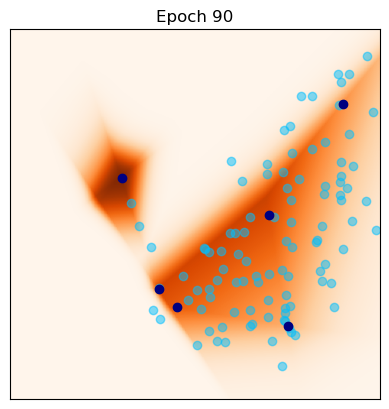

[91/100] 	Loss_D: 0.9634	Loss_G: -0.4218
[92/100] 	Loss_D: 0.9168	Loss_G: -0.5206
[93/100] 	Loss_D: 0.9620	Loss_G: -0.4293
[94/100] 	Loss_D: 0.9136	Loss_G: -0.5742
[95/100] 	Loss_D: 0.9207	Loss_G: -0.5294
[96/100] 	Loss_D: 0.9529	Loss_G: -0.5122
[97/100] 	Loss_D: 0.9306	Loss_G: -0.6456
[98/100] 	Loss_D: 1.0062	Loss_G: -0.4648
[99/100] 	Loss_D: 0.9718	Loss_G: -0.5936


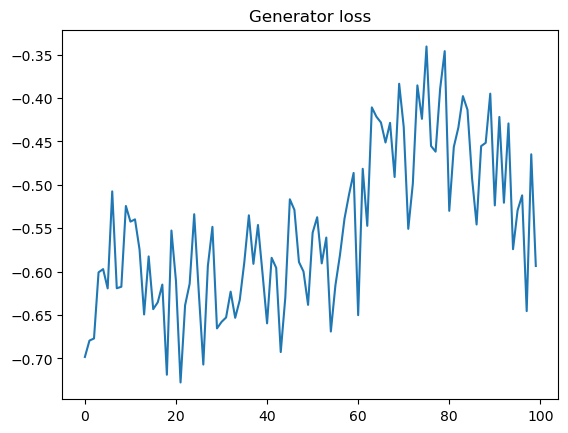

In [16]:
lr = 0.002  # learning rate for generator
lrdisc = 0.002  # learning rate for generator

## parameters for training
n_epochs = 100
niterD = 100
niterG = 1

torch.manual_seed(1)  # initialize random seed for reproducibility

# Initialize generators and discriminators
G = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
optimG = optim.Adam(G.parameters(), lr=lr)

D = Discriminator(n_in=d, n_hid=10).to(device)
optimD = optim.Adam(D.parameters(), lr=lrdisc, betas=(beta_1, beta_2))

Glosses = []
Dlosses = []

iter_display = 10

# Main loop
for epoch in range(n_epochs):
    ############################
    ### Train discriminator (niterD iterations)
    ############################
    for iter in range(0, niterD):
        optimD.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z).detach()

        inp = torch.cat((D(y), D(x)))
        target = torch.cat((V1, V0))

        Dloss = criterion(inp, target)
        # Equivalently:
        # Dloss = - torch.mean(torch.log(sig(D(y)))) - torch.mean(torch.log(1 - sig(D(x))))

        Dloss.backward()
        optimD.step()

    ############################
    ### Train generator (niterG iterations)
    ############################
    for iter in range(0, niterG):
        optimG.zero_grad()

        z = torch.randn(b, n_in, device=device)
        x = G(z)

        Gloss = torch.mean(torch.log(1 - sig(D(x))))

        Gloss.backward()
        optimG.step()

    # Output training stats
    print(
        "[%d/%d] \tLoss_D: %.4f\tLoss_G: %.4f"
        % (epoch, n_epochs, Dloss.item(), Gloss.item())
    )
    Glosses.append(Gloss.item())
    Dlosses.append(-Dloss.item())

    if epoch % iter_display == 0:
        Dxgrid = sig(D(xgrid)).detach().cpu().numpy().reshape(nr, nc)
        z = torch.randn(b, 1, n_in, device=device)
        x = G(z)
        xd = x.detach().squeeze(1)
        strtitle = "Epoch " + str(epoch)
        fig = plt.figure(dpi=100)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Dxgrid, cmap="Oranges", extent=extent)  # discriminator
        plt.scatter(xd[:, 0].cpu(), xd[:, 1].cpu(), c="deepskyblue", alpha=0.5)
        plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), c="navy")
        plt.title(strtitle)
        plt.show()

# Save final generator for later use
gan = Generator(n_in=n_in, n_out=d, n_hid=10, nlayers=3, device=device)
gan.load_state_dict(G.state_dict())

### Plot the evolution of the discriminator loss ###
plt.figure(dpi=100)
plt.plot(Glosses)
plt.title("Generator loss")
plt.show()